In [4]:
import os 
import time
import copy
from tqdm import tqdm

import numpy as np 
import matplotlib.pyplot as plt
import scipy
from scipy import sparse, linalg, fft
from scipy.linalg import expm, sinm, cosm
import scipy.integrate as integrate
from scipy.integrate import quad
import pandas as pd

from joblib import Parallel, delayed
from numba import jit, njit, prange

import functools

############ Macros ###############
np.random.seed(0)

# Physical constants
K = 9 # number of fermionic modes
J = 4 # ~"energy scale"
Q_COUPLING = 3 # order of coupling, don't want to use the letter 'Q' because that denotes the supercharge
N = 2*K # number of fermions
N_DIM = 2**K # Hilbert space dimension

N_SAMPLES = 100 # number of samples to generate
N_JOBS = 20 # number of jobs to run in parallel


Just like normal SYK, we're still interested in Majorana fermions...

## 1. Define fermionic modes

In [5]:
cr = sparse.csr_array(np.array([[0,1],[0,0]]))
an = sparse.csr_array(np.array([[0,0],[1,0]]))
id = sparse.csr_array(np.identity(2))
id2 = sparse.csr_array(np.array([[-1,0],[0,1]]))

def c(n):
    factors = [id for i in range(n-1)]+[cr]+[id2 for i in range(K-n)]
    out = factors[0]
    for i in range(1, K):
        out = sparse.kron(out,factors[i])
    return out

def cd(n):
    factors = [id for i in range(n-1)]+[an]+[id2 for i in range(K-n)]
    out = factors[0]
    for i in range(1, K):
        out = sparse.kron(out,factors[i])
    return out

### 1.a. Check that fermionic modes satisfy algebra

$\{c_i, c_j\}=\{c_i^\dagger, c_j^\dagger\}=0$,     $\{c_i,c_j^\dagger\}=\delta_{ij}$

In [3]:
def anticommutator(a,b):
    return a@b+b@a
    
c_algebra_satisfied = True
tic = time.time()
for i in range(1,K+1):
    c_i = c(i)
    cd_i = cd(i)
    
    for j in range(1,K+1):
        c_j = c(j)
        cd_j = cd(j)

        ac_ci_cj = anticommutator(c_i, c_j).toarray()
        if not np.allclose(ac_ci_cj, np.zeros((N_DIM, N_DIM))):
            c_algebra_satisfied = False

        ac_cdi_cdj = anticommutator(cd_i, cd_j).toarray()
        if not np.allclose(ac_cdi_cdj, np.zeros((N_DIM, N_DIM))):
            c_algebra_satisfied = False

        ac_ci_cdj = anticommutator(c_i, cd_j).toarray()
        if i==j:
            if not np.allclose(ac_ci_cdj, np.identity(N_DIM)):
                c_algebra_satisfied = False
        else:
            if not np.allclose(ac_ci_cdj, np.zeros((N_DIM, N_DIM))):
                c_algebra_satisfied = False

toc = time.time()
duration = toc - tic
print(f"Duration: {duration//60} minutes, {duration%60} seconds")

print(f"Fermionic mode algebra satisfied: {c_algebra_satisfied}")

Duration: 0.0 minutes, 25.573275327682495 seconds
Fermionic mode algebra satisfied: True


## 2. Define fermions

In [6]:
psi = [None for i in range(N)] 
for i in range(1,K+1):
    psi[2*(i-1)] = sparse.csr_matrix((c(i)+cd(i))/np.sqrt(2))
    psi[2*(i-1)+1] = sparse.csr_matrix((c(i)-cd(i))*(-1j/np.sqrt(2)))

### 2.a. Check that fermions satisfy algebra

$\{\psi_i, \psi_j\} = \delta_{ij}$

In [7]:
psi_algebra_satisfied = True
for i in range(N):
    psi_i = psi[i]

    for j in range(N):
        psi_j = psi[j]

        ac_pi_pj = anticommutator(psi_i, psi_j)

        if i==j:
            if not np.allclose(ac_pi_pj.toarray(), np.identity(N_DIM)):
                psi_algebra_satisfied = False
                
        else:
            if not np.allclose(ac_pi_pj.toarray(), np.zeros((N_DIM, N_DIM))):
                psi_algebra_satisfied = False
        
print(f"Fermion algebra satisfied: {psi_algebra_satisfied}")

Fermion algebra satisfied: True


## Define the supercharge, Q

First let's quickly precompute pairwise inner-product

In [8]:
psi_pairs = [None for i in range(N**2)] 
for i in range(N-1):
    for j in range(i+1, N):
        index = i*N+j
        psi_pairs[index] = psi[i]@psi[j]

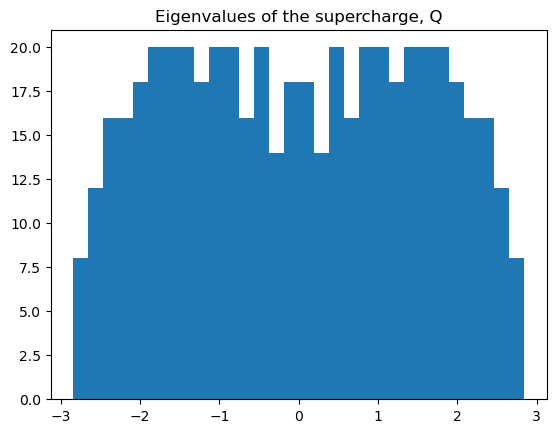

Q hermitian:  True


In [9]:
sigma_c = np.sqrt(2*J/(N**2))
cs_test = np.random.normal(0, sigma_c, size=(N, N, N))

Q = sparse.csr_matrix(np.zeros((N_DIM, N_DIM), dtype=np.complex128))
for i in range(N-2):
    for j in range(i+1, N-1):
        for k in range(j+1, N):
            Q += (1j**(Q_COUPLING))*cs_test[i,j,k]*psi[i]@psi[j]@psi[k]

iv = np.linalg.eigvalsh(Q.toarray())
plt.figure()
plt.hist(iv, bins=30)
plt.title("Eigenvalues of the supercharge, Q")
plt.show()
plt.close()

print("Q hermitian: ", linalg.ishermitian(Q.toarray()))

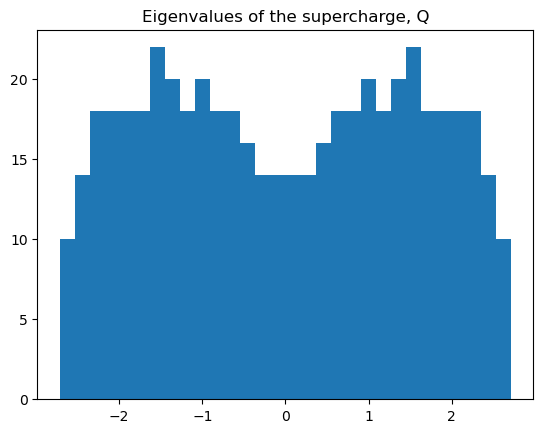

Q hermitian:  True


In [10]:
Q_COUPLING=3
sigma_c = np.sqrt(2*J/(N**2))
cs_test = np.random.normal(0, sigma_c, size=(N, N, N))

Q = sparse.csr_matrix(np.zeros((N_DIM, N_DIM), dtype=np.complex128))
for i in range(N-2):
    for j in range(i+1, N-1):
        index_ij = i*N+j
        psi_ij = psi_pairs[index_ij]

        for k in range(j+1, N):
            psi_k = psi[k]
            Q += cs_test[i,j,k]*psi_ij@psi_k

exp = Q_COUPLING
Q *= (1j**exp)
iv = np.linalg.eigvalsh(Q.toarray())
plt.figure()
plt.hist(iv, bins=30)
plt.title("Eigenvalues of the supercharge, Q")
plt.show()
plt.close()

print("Q hermitian: ", linalg.ishermitian(Q.toarray()))

How about Q=2 or 5?

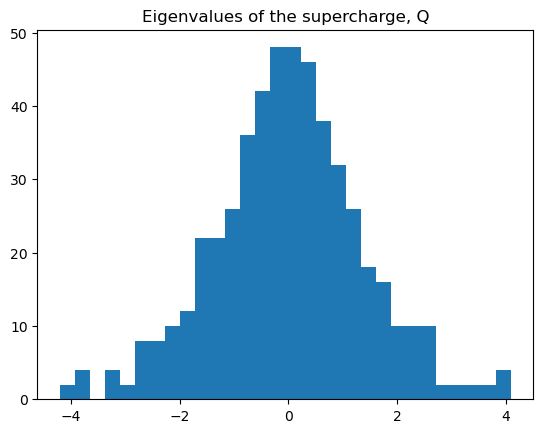

Q hermitian:  False


In [11]:
Q_COUPLING=2
sigma_c = np.sqrt(2*J/(N**2))
cs_test = np.random.normal(0, sigma_c, size=(N, N))

Q = sparse.csr_matrix(np.zeros((N_DIM, N_DIM), dtype=np.complex128))
for i in range(N-1):
    for j in range(i+1, N):
        Q += cs_test[i,j]*psi_pairs[i*N+j]

exp = Q_COUPLING/2
Q *= (1j**exp)*Q

iv = np.linalg.eigvalsh(Q.toarray())
plt.figure()
plt.hist(iv, bins=30)
plt.title("Eigenvalues of the supercharge, Q")
plt.show()
plt.close()

print("Q hermitian: ", linalg.ishermitian(Q.toarray()))

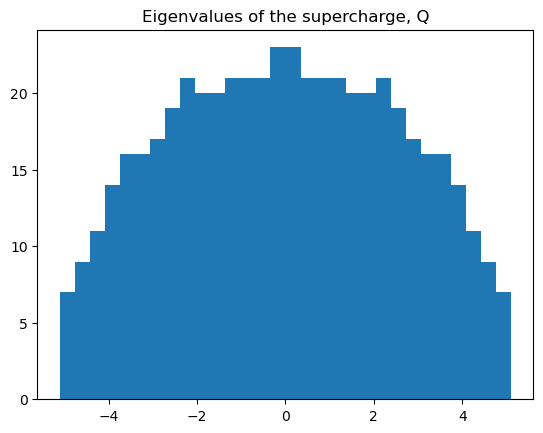

Q hermitian:  True


In [12]:
Q_COUPLING = 5
sigma_c = np.sqrt(2*J/(N**2))
cs_test = np.random.normal(0, sigma_c, size=(N, N, N, N, N))

Q = sparse.csr_matrix(np.zeros((N_DIM, N_DIM), dtype=np.complex128))
for i in range(N-4):
    for j in range(i+1, N-3):
        psi_ij = psi_pairs[i*N+j]
        
        for k in range(j+1, N-2):
            for l in range(k+1, N-1):
                psi_kl = psi_pairs[k*N+l]

                for m in range(l+1, N):
                    Q += cs_test[i,j,k,l,m]*psi_ij@psi_kl@psi[m]

exp = Q_COUPLING-1
Q *= (1j**exp)

iv = np.linalg.eigvalsh(Q.toarray())
plt.figure()
plt.hist(iv, bins=30)
plt.title("Eigenvalues of the supercharge, Q")
plt.show()
plt.close()

print("Q hermitian: ", linalg.ishermitian(Q.toarray()))